# Bayesian Statistics Seminar

Copyright 2017 Allen Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np

from thinkbayes2 import Suite
import thinkplot

## Bayesian bandits


Here's a definition for `Bandit`, which extends `Suite` and defines a likelihood function that computes the probability of the data (win or lose) for a given value of `x` (the probability of win).

Note that `hypo` is in the range 0 to 100.

In [2]:
class Bandit(Suite):
    
    def Likelihood(self, data, hypo):
        """ 
        hypo is the prob of win (0-100)
        data is a string, either 'W' or 'L'
        """
        x = hypo / 100
        if data == 'W':
            return x
        else:
            return 1-x

We'll start with a uniform distribution from 0 to 100.

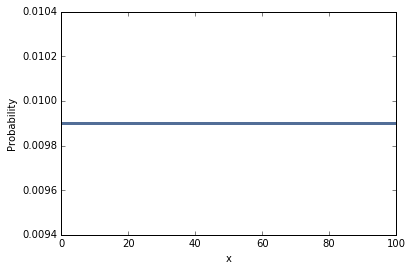

In [3]:
bandit = Bandit(range(101))
thinkplot.Pdf(bandit)
thinkplot.Config(xlabel='x', ylabel='Probability')

Now we can update with a single loss:

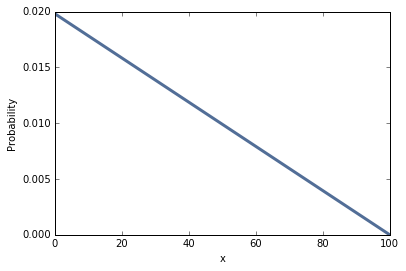

In [4]:
bandit.Update('L')
thinkplot.Pdf(bandit)
thinkplot.Config(xlabel='x', ylabel='Probability')

Another loss:

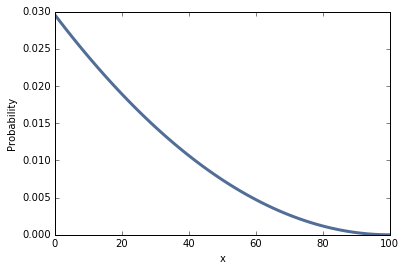

In [5]:
bandit.Update('L')
thinkplot.Pdf(bandit)
thinkplot.Config(xlabel='x', ylabel='Probability')

And a win:

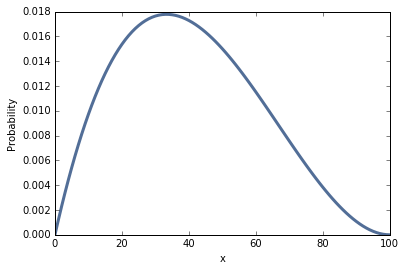

In [6]:
bandit.Update('W')
thinkplot.Pdf(bandit)
thinkplot.Config(xlabel='x', ylabel='Probability')

Starting over, here's what it looks like after 1 win and 9 losses.

10

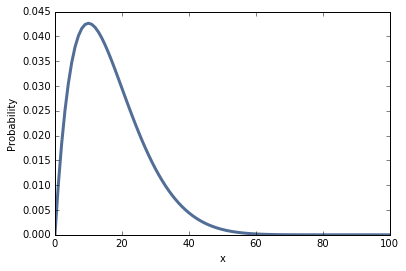

In [7]:
bandit = Bandit(range(101))

for outcome in 'LLWLLLLLLL':
    bandit.Update(outcome)

thinkplot.Pdf(bandit)
thinkplot.Config(xlabel='x', ylabel='Probability')
bandit.MaximumLikelihood()

The posterior mean is about 17%

In [8]:
bandit.Mean()

16.68194469884906

The most likely value is the observed proportion 1/10

In [9]:
bandit.MaximumLikelihood()

10

The posterior credible interval has a 90% chance of containing the true value (provided that the prior distribution truly represents our background knowledge).

In [10]:
bandit.CredibleInterval(90)

(3, 36)

## Bayesian A/B testing

Now suppose we have several bandits and we want to decide which one to play.

As an example, suppose we have 4 machines with these probabilities:

In [11]:
actual_probs = [10, 20, 30, 40]

The following function simulates playing one machine once.

In [12]:
from random import random
from collections import Counter

counter = Counter()

def flip(p):
    """Returns True with probablity `p`, False otherwise.
    
    p: float probability
    
    returns: boolean
    """
    return random() < p

def play(i):
    """Plays the `i`th machine and returns the outcome.
    
    i: integer index into `actual_probs`
    """
    counter[i] += 1
    p = actual_probs[i] / 100
    if flip(p):
        return 'W'
    else:
        return 'L'

Here's a test, playing Machine 3 twenty times:

In [13]:
for i in range(20):
    result = play(3)
    print(result, end=' ')

L L W L W L W W W L W L L W W L L L L L 

**Exercise 1** Create a `Bandit` object to represent your beliefs about Machine 3.  Write a loop that plays Machine 3 20 times and updates your beliefs based on the outcome.  Plot the posterior distribution of `x` and the 90% credible interval.  Does the CI contain the actual probability for Machine 3, which is 30%?

(21, 54)


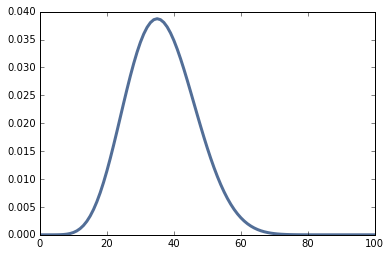

In [14]:
# Solution

mach3 = Bandit(range(101))
for i in range(20):
    result = play(3)
    mach3.Update(result)
    
thinkplot.Pdf(mach3)
print(mach3.CredibleInterval(90))

## STOP HERE.

## The strategy

Now I'll make 4 `Bandit` objects to represent our beliefs about the 4 machines.

In [15]:
prior = range(101)
beliefs = [Bandit(prior) for i in range(4)]

The core of the Bayesian Bandits Strategy is this process for choosing which machine to play:

In [16]:
def choose(beliefs):
    """Chooses a machine in proportion to its probability of superiority.
    
    beliefs: list of Bandit objects.
    
    returns: integer index of the chosen machine.
    """
    ps = [b.Random() for b in beliefs]
    return np.argmax(ps)

It chooses a random value from each posterior and returns the index of the machine with this highest generated value of `x`.

Here's an example.

In [17]:
choose(beliefs)

0

This function updates our beliefs about one of the machines based on one outcome.

In [18]:
def update(beliefs, i, outcome):
    """Updates Machine `i` based on `outcome`.
    
    beliefs: list of Bandit objects.
    i: index integet into beliefs
    outcome: string, either 'W' or 'L'
    """
    beliefs[i].Update(outcome)

**Exercise 2**  Fill in this function to use `choose` to pick a machine, `play` to play it, and `update` to update our beliefs about the chosen machine.

In [19]:
def choose_play_update(beliefs, verbose=False):
    """Chooses a machine, plays it, and updates `beliefs`.
    
    If `verbose`, print the index of the chosen machine, `i`,
    and the `outcome`.
    
    beliefs: list of Bandit objects.
    verbose: boolean
    """
    pass

In [20]:
# Solution

def choose_play_update(beliefs, verbose=False):
    """Chooses a machine, plays it, and updates `beliefs`.
    
    If `verbose`, print the index of the chosen machine, `i`,
    and the `outcome`.
    
    beliefs: list of Bandit objects.
    verbose: boolean
    """
    i = choose(beliefs)
    outcome = play(i)
    update(beliefs, i, outcome)
    if verbose:
        print(i, outcome, beliefs[i].Mean())

Test your method here.

In [21]:
counter = Counter()
choose_play_update(beliefs, verbose=True)

0 L 33.0


## Testing the bandit strategy

Start with a fresh batch of `Bandit` objects.

In [22]:
prior = range(101)
beliefs = [Bandit(prior) for i in range(4)]

And reset the counter that keeps track of how many times we play each machine.

In [23]:
counter = Counter()

This function displays the four distributions:

In [24]:
options = dict(yticklabels='invisible')

def plot(beliefs):
    thinkplot.preplot(rows=2, cols=2)
    for i, b in enumerate(beliefs):
        thinkplot.subplot(i+1)
        thinkplot.Pdf(b, label=i)
        thinkplot.config(**options)

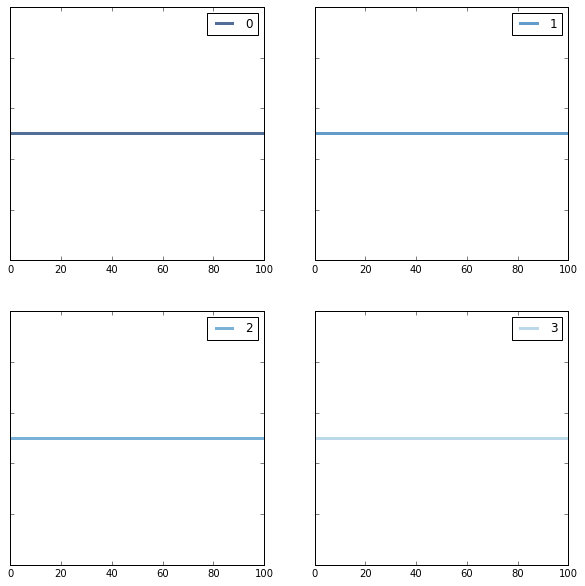

In [25]:
plot(beliefs)

Now we can play a few times and see how `beliefs` gets updated:

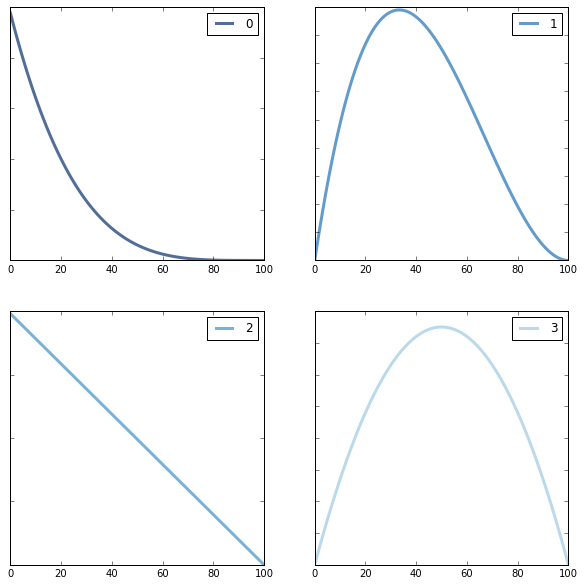

In [26]:
for i in range(10):
    choose_play_update(beliefs)
    
plot(beliefs)

If we play 90 more times, the estimates get better.

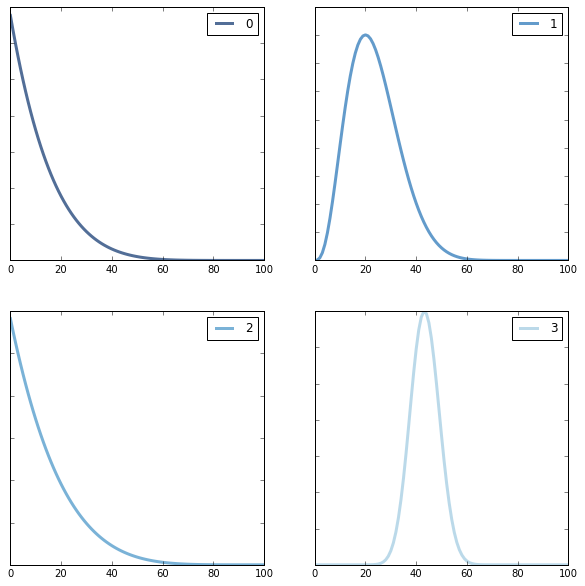

In [27]:
for i in range(90):
    choose_play_update(beliefs)
    
plot(beliefs)

We can summarize `beliefs` by printing the posterior means and credible intervals:

In [28]:
for i, b in enumerate(beliefs):
    print(b.Mean(), b.CredibleInterval(90))

12.0675787728 (0, 34)
23.5293975696 (9, 42)
13.8614072846 (0, 39)
43.4210526316 (34, 53)


The credible intervals usually contain the true value, but the estimates are still rough, especially for the lower-probability machines.  But that's not the important part.  

The goal is to play the high-probability machines most often.  Making the estimates more precise is a means to that end, but not an end itself.

Let's see how often we played each machine.

In [29]:
for machine, count in sorted(counter.items()):
    print(machine, count)

0 6
1 15
2 5
3 74


**Exercise 3** Run another 100 iterations.  How many times do we play the best machine?

In [30]:
# Solution

counter = Counter()
for i in range(100):
    choose_play_update(beliefs)

for machine, count in sorted(counter.items()):
    print(machine, count)


1 3
2 3
3 94
